In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
#from sklearn.manifold import TSNE

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering

/home/qara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Embedding default loaded


In [2]:
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict

phraser_default.bin  loaded
keyword dictionary loaded


# Pickle Functions

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


# Embedding

In [4]:
embedding = EmbeddingModel().get_embedding

Embedding default loaded


In [5]:
train_data = load_obj('seq2seq_embed')
len(train_data)

557440

# Generator

In [119]:
def generator(data, bs):
    np.random.shuffle(data)
    for i in range(len(data)//bs):
        batch = data[bs*i: bs*(i+1)]

        x_gen = list(map(lambda k: np.pad(k, \
                ((40-len(k),0),(0,0)),'constant'), batch))
        mask_gen = list(map(lambda k: np.array(\
                [0 for i in range(40-len(k))] + \
                [1 for j in range(len(k))]), batch))

        yield np.array(list(x_gen)), np.array(list(mask_gen))

# Model

In [132]:
class mixmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr=1e-4, alpha=1, beta=1):
        title_len = 40
        em_dim = 100
        hidden_dim = 100
        
        self.n_z = n_z
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
    
        self.x = tf.placeholder(tf.float32, [None, title_len, em_dim])
        self.mask = tf.placeholder(tf.float32, [None, title_len])
    
        ### Seq2seq Encoder ###
        encoder_cell = tf.contrib.rnn.LSTMCell(hidden_dim)
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, self.x,
            dtype=tf.float32, time_major=False,
        )

        self.sentence_embed = encoder_final_state[1]
        
        ### VAE Encoder ###
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.sentence_embed, 100, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 64, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 32, scope='enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 32, scope='enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 16, scope='enc_fc6', activation_fn=tf.nn.elu)
        f7 = fc(f6, 16, scope='enc_fc7', activation_fn=tf.nn.elu)
        f8 = fc(f7, 8, scope='enc_fc8', activation_fn=tf.nn.elu)
        f9 = fc(f8, 8, scope='enc_fc9', activation_fn=tf.nn.elu)
        f10 = fc(f9, 4, scope='enc_fc10', activation_fn=tf.nn.elu)
        self.z_mu = fc(f10, self.n_z, scope='enc_fc11_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f10, self.n_z, scope='enc_fc11_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> x_hat
        g1 = fc(self.z, 4, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 8, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 8, scope='dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 16, scope='dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 16, scope='dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 32, scope='dec_fc6', activation_fn=tf.nn.elu)
        g7 = fc(g6, 32, scope='dec_fc7', activation_fn=tf.nn.elu)
        g8 = fc(g7, 64, scope='dec_fc8', activation_fn=tf.nn.elu)
        g9 = fc(g8, 64, scope='dec_fc9', activation_fn=tf.nn.elu)
        g10 = fc(g9, 100, scope='dec_fc10', activation_fn=tf.nn.elu)
        self.sentence_embed_hat = fc(g10, 100, scope='dec_fc11', activation_fn=None)

        ### Seq2seq Decoder ###
        s_code = tf.reshape(self.sentence_embed_hat, [-1, 1, hidden_dim])
        decoder_cell = tf.contrib.rnn.LSTMCell(em_dim)
        decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
            decoder_cell, tf.tile(s_code, [1, title_len, 1]),
            initial_state = encoder_final_state,
            dtype=tf.float32, time_major=False, scope="plain_decoder",
        )

        x_ = tf.reverse(decoder_outputs, [1])
        # Reconstruction loss
        self.embed_loss = self.alpha * tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        l2_loss = tf.reduce_mean(tf.squared_difference(self.x, x_), axis=2)
        self.recon_loss = tf.reduce_mean(l2_loss * self.mask)
        
        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.loss = self.embed_loss + self.recon_loss + self.latent_loss
        self.train = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.loss)
        self.output = x_
        

In [160]:
tf.reset_default_graph()
model = mixmodel(n_z=4, sigma=1e-3, lr=1e-3, alpha=10, beta=10)

tfconfig = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess=tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

### Load Model

In [162]:
model_name = 'mixmodel_100'
saver = tf.train.Saver()
saver.restore(sess, './ckpt/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt/mixmodel_100.ckpt


### Training

In [ ]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=100

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    avg_embed_loss = 0
    avg_recon_loss = 0
    avg_latent_loss = 0
    
    for batch in generator(train_data, bs):
        loss, e_loss, r_loss, l_loss , _ = sess.run([model.loss, \
                model.embed_loss, model.recon_loss, model.latent_loss, model.train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        avg_embed_loss += e_loss
        avg_recon_loss += r_loss
        avg_latent_loss += l_loss
        
        count += 1
        if count%print_step==0:
            print('steps: %d / total loss: %.4f, embed: %.4f, recon: %.4f, latent: %.4f'\
                 %(count, avg_loss/count, avg_embed_loss/count, avg_recon_loss/count, avg_latent_loss/count))
    

    saver.save(sess, './ckpt/mixmodel_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps: 100 / total loss: 0.0447, embed: 0.0196, recon: 0.0156, latent: 0.0095
steps: 200 / total loss: 0.0330, embed: 0.0131, recon: 0.0151, latent: 0.0048
steps: 300 / total loss: 0.0281, embed: 0.0100, recon: 0.0149, latent: 0.0032
steps: 400 / total loss: 0.0253, embed: 0.0081, recon: 0.0147, latent: 0.0024
steps: 500 / total loss: 0.0235, embed: 0.0069, recon: 0.0146, latent: 0.0020
Epoch: [2/100]
steps: 100 / total loss: 0.0154, embed: 0.0012, recon: 0.0142, latent: 0.0000
steps: 200 / total loss: 0.0153, embed: 0.0011, recon: 0.0142, latent: 0.0000
steps: 300 / total loss: 0.0152, embed: 0.0010, recon: 0.0142, latent: 0.0000
steps: 400 / total loss: 0.0151, embed: 0.0009, recon: 0.0141, latent: 0.0000
steps: 500 / total loss: 0.0150, embed: 0.0009, recon: 0.0141, latent: 0.0000
Epoch: [3/100]
steps: 100 / total loss: 0.0145, embed: 0.0005, recon: 0.0140, latent: 0.0000
steps: 200 / total loss: 0.0144, embed: 0.0005, recon: 0.0139, latent: 0.0000
steps: 300 / total 

# Evaluation

In [135]:
def generate_seq2seq(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    tf.reset_default_graph()
    output = sess.run(model.output, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

In [122]:
total_data = load_obj('upper1')

In [163]:
index = 1
test_s2s = generate_seq2seq(top_news.lemmatized[index], model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
print(top_news.lemmatized[index])

['pakistan', 'gunman', 'stop', 'van', 'contain', 'teacher', 'educate', 'girl', 'shoot', 'murder', 'teacher', 'aid', 'worker']


In [165]:
for i in range(len(test_s2s)):
    print(top_news.lemmatized[index][i])
    print(embedding.similar_by_vector(test_s2s[i]))
    print()

pakistan
[('muslim', 0.8651015758514404), ('islamic', 0.8599182367324829), ('islamic_state', 0.8355435729026794), ('destroy_islamic', 0.8350486755371094), ('palestinian_terrorist', 0.8328242301940918), ('muslim_terrorist', 0.8267549276351929), ('iraqi_christian', 0.8197015523910522), ('terrorist', 0.8189867734909058), ('pakistan', 0.818328857421875), ('clash_islamic', 0.817404568195343)]

gunman
[('muslim', 0.8996880054473877), ('islamic', 0.8845473527908325), ('terrorist', 0.8711717128753662), ('islamic_terrorist', 0.8686994910240173), ('muslim_christian', 0.8685338497161865), ('muslim_terrorist', 0.8658732771873474), ('jihad', 0.8640064001083374), ('palestinian_terrorist', 0.8613203167915344), ('violent_jihad', 0.8603305220603943), ('islamic_state', 0.8594715595245361)]

stop
[('policeman', 0.8216572999954224), ('murder', 0.8203737139701843), ('kill', 0.8120800256729126), ('protest', 0.8115200996398926), ('polouse', 0.8014346957206726), ('arrest', 0.7997252941131592), ('christian', 0

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [166]:
index = 1
test_s2s = generate_seq2seq(total_data.lemmatized[index], model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [167]:
print(total_data.lemmatized[index])

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']


In [168]:
for i in range(len(test_s2s)):
    print(total_data.lemmatized[index][i])
    print(embedding.similar_by_vector(test_s2s[i]))
    print()

president
[('insist', 0.8229811787605286), ('invite', 0.7954767942428589), ('remind', 0.7830241322517395), ('press', 0.7742473483085632), ('contention', 0.7713900804519653), ('businessman', 0.7694128751754761), ('president_obama', 0.7655007839202881), ('politician', 0.758459210395813), ('white_house', 0.758399486541748), ('supporter', 0.7519349455833435)]

obama
[('obama', 0.8795356154441833), ('politician', 0.8727269172668457), ('president_obama', 0.8588958978652954), ('democratic_congresswoman', 0.8564929962158203), ('politicize', 0.8531311750411987), ('leftist', 0.8449838757514954), ('barack_obama', 0.8448082208633423), ('supporter', 0.8444757461547852), ('liberal', 0.8440057039260864), ('democratic_party', 0.8385233879089355)]

want
[('matter', 0.8058760762214661), ('argue', 0.7907227277755737), ('insist', 0.7827374935150146), ('question', 0.7740395069122314), ('advocate', 0.7724536657333374), ('indeed', 0.7714610695838928), ('politician', 0.7605513334274292), ('neither', 0.7587474

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Distribution

In [52]:
total_data = load_obj('total_data')

idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])

hot_news = total_data[total_data.score>=1000]
#common_news = total_data[total_data.score==0]

top_news = top_news.reset_index(drop=True)
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
#common_news = common_news.sort_values(by='date').reset_index(drop=True)

In [174]:
def generate_from_df(df):
    x = []
    mask = []
    for idx, row in df.iterrows():
        title = list(row.lemmatized)
        title = [x for x in title if len(x)!=1]

        k = embedding[title]
        x.append(np.pad(k, ((40-len(k),0), (0,0)), 'constant'))
        mask.append(np.array([0 for i in range(40-len(k))] + [1 for i in range(len(k))]))
        
    yield np.array(list(x)), np.array(list(mask))

def extract_code(df, bs=0):
    codes = []
    c=0
    if bs==0:
        bs = len(df)
    for i in range((len(df))//bs):
    #for i in range((len(df)+bs-1)//bs):
        small_df = df[bs*i:bs*(i+1)]
        for x, mask in generate_from_df(small_df):
            c += 1
            code = sess.run(model.z_mu, feed_dict={
                model.x: x, model.mask: mask
            })
            codes.append(code)

            if c*bs%1000==0:
                print(c*bs)
    codes = np.array(list(codes))
    codes = np.reshape(codes, [-1, 4])
    return codes

def show_embeds(codes):
    colors = cm.rainbow(np.linspace(1, 0, len(codes)))
    fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
    x1 = codes[:, 0]
    for idx in range(1, model.n_z):
        y1 = codes[:, idx]
        #ax[idx-1].set_xlim(-0.4, 0.4)
        #ax[idx-1].set_ylim(-0.4, 0.4)
        ax[idx-1].scatter(x1, y1, color=colors, s=5)

    plt.show()

In [175]:
top_codes = extract_code(top_news,10)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1000


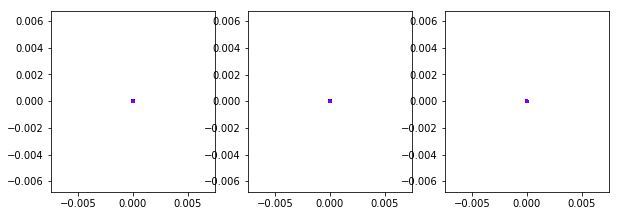

In [176]:
show_embeds(top_codes)